In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.utils.np_utils import to_categorical 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
import tensorflow as tf

In [ ]:
mypath= '/content/drive/MyDrive/Batik Jogja'

In [ ]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [ ]:
# memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Batik Ceplok         80
Batik Kawung         80
Batik Parang         80
Batik Sekar Jagad    80
Batik Tambal         80
dtype: int64

In [ ]:
#cek sample datanya
df.head()

,path,file_name,tag
0,/content/drive/MyDrive/Batik Jogja/Batik Kawun...,kawung v7 test (2).jpg,Batik Kawung
1,/content/drive/MyDrive/Batik Jogja/Batik Kawun...,kawung v7 test (8).jpg,Batik Kawung
2,/content/drive/MyDrive/Batik Jogja/Batik Kawun...,kawung v7 test (6).jpg,Batik Kawung
3,/content/drive/MyDrive/Batik Jogja/Batik Kawun...,kawung v7 test (1).jpg,Batik Kawung
4,/content/drive/MyDrive/Batik Jogja/Batik Kawun...,kawung v7 test (3).jpg,Batik Kawung


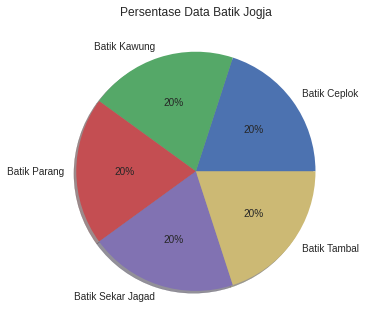

In [ ]:
target, count = np.unique(df['tag'], return_counts=True)
precentange = [x / np.sum(count) for x in count]
plt.style.use('seaborn')
plt.pie(precentange, labels = target,  autopct='%1.f%%', shadow=True)
plt.title('Persentase Data Batik Jogja')
plt.show()

# **Train test split**

In [ ]:
#load library untuk train test split
from sklearn.model_selection import train_test_split

In [ ]:
#variabel yang digunakan pada pemisahan data ini
X= df['path']
y= df['tag']

In [ ]:
# split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.2, random_state=300)

In [ ]:
df_train = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_test = pd.DataFrame({'path':X_test
              ,'tag':y_test
             ,'set':'test'})

In [ ]:
print('train size', len(df_train))
print('test size', len(df_test))

train size 320
test size 80


In [ ]:
df_all = df_train.append(df_test).reset_index(drop=1)
print(df_all.groupby(['set','tag']).size(),'\n')

set    tag              
test   Batik Ceplok         15
       Batik Kawung         23
       Batik Parang         10
       Batik Sekar Jagad    17
       Batik Tambal         15
train  Batik Ceplok         65
       Batik Kawung         57
       Batik Parang         70
       Batik Sekar Jagad    63
       Batik Tambal         65
dtype: int64 



# **Merapihkan ke folder set masing-masing**

In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
datasource_path = "/content/drive/MyDrive/Batik Jogja/"
dataset_path = "/content/dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [ ]:
df_all.head()

In [ ]:
!zip -r /content/file.zip /content/dataset

In [ ]:
from google.colab import files
files.download("/content/file.zip")

# **Mempersiapkan variabel global untuk training**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.utils.np_utils import to_categorical 
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_width, img_height = 224, 224

train_data_dir = '/content/drive/MyDrive/dataset/train'
test_data_dir = '/content/drive/MyDrive/dataset/test'
 
batch_size = 32

# **Mempersiapkan dataset pipeline dan augmentation Untuk proses pembuatan dataset**

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False)
datagen = ImageDataGenerator(rescale=1. / 255,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True) 

In [ ]:
train_generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical', 
    shuffle=False) 
 
nb_train_samples = len(train_generator.filenames) 
num_classes = len(train_generator.class_indices) 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
train_data = vgg16.predict(train_generator) 
train_labels = train_generator.classes  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 320 images belonging to 5 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,
     color_mode="rgb",  
     class_mode='categorical',  
     shuffle=False)  
   
nb_validation_samples = len(validation_generator.filenames)   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))   
features_validation = vgg16.predict(validation_generator, predict_size_validation)   
validation_data = vgg16.predict(validation_generator)
validation_labels = validation_generator.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 80 images belonging to 5 classes.


In [ ]:
print (generator_top.class_indices)
labels = '\n'.join(sorted(generator_top.class_indices.keys()))
with open('labels.txt', 'w') as f:
  f.write(labels)

{'Batik Ceplok': 0, 'Batik Kawung': 1, 'Batik Parang': 2, 'Batik Sekar Jagad': 3, 'Batik Tambal': 4}


In [ ]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=train_data.shape[1:]),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same'),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 64)          0

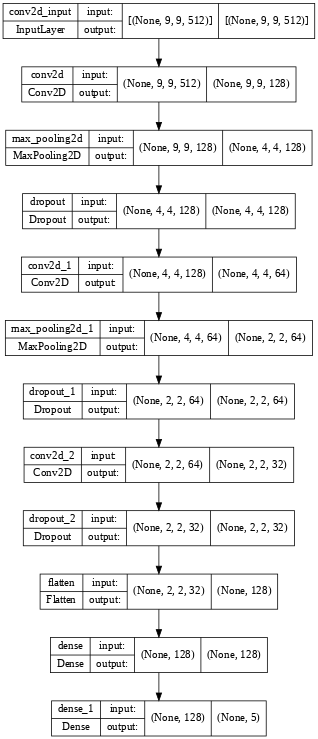

In [ ]:
model_viz = tf.keras.utils.plot_model(model,
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='TB',
                          expand_nested=True,
                          dpi=55)
model_viz

In [ ]:
history = model.fit(train_data, train_labels, 
   epochs=100,
   batch_size=batch_size, 
   validation_data=(test_data, test_labels))  
(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
print('[INFO] accuracy: {:.2f}%'.format(eval_accuracy * 100)) 
print('[INFO] Loss: {}'.format(eval_loss)) 

Epoch 1/100
10/10 [==============================] - 3s 196ms/step - loss: 1.7284 - accuracy: 0.2062 - val_loss: 1.5883 - val_accuracy: 0.3125
Epoch 2/100
10/10 [==============================] - 2s 172ms/step - loss: 1.6468 - accuracy: 0.2406 - val_loss: 1.5891 - val_accuracy: 0.3875
Epoch 3/100
10/10 [==============================] - 2s 170ms/step - loss: 1.5980 - accuracy: 0.2250 - val_loss: 1.5920 - val_accuracy: 0.2375
Epoch 4/100
10/10 [==============================] - 2s 169ms/step - loss: 1.6186 - accuracy: 0.2125 - val_loss: 1.5562 - val_accuracy: 0.5250
Epoch 5/100
10/10 [==============================] - 2s 173ms/step - loss: 1.5507 - accuracy: 0.3281 - val_loss: 1.5104 - val_accuracy: 0.4125
Epoch 6/100
10/10 [==============================] - 2s 171ms/step - loss: 1.5226 - accuracy: 0.3531 - val_loss: 1.4219 - val_accuracy: 0.4875
Epoch 7/100
10/10 [==============================] - 2s 168ms/step - loss: 1.4195 - accuracy: 0.3781 - val_loss: 1.3167 - val_accuracy: 0.4875

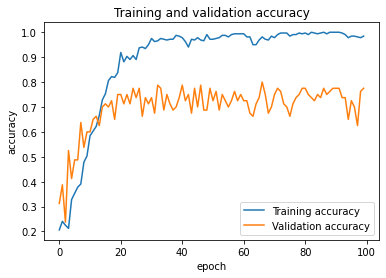

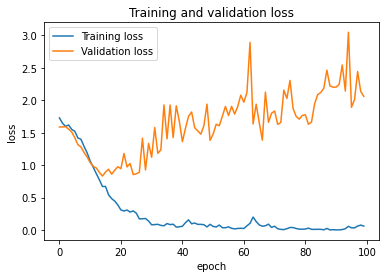

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data, test_labels)

3/3 [==============================] - 0s 46ms/step - loss: 2.0602 - accuracy: 0.7750


[2.0601799488067627, 0.7749999761581421]

In [ ]:
model.save('my_model.h5')